In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("/content/drive/MyDrive/pre/data_new.csv")

In [ ]:
data = pd.read_csv("data_new.csv")

In [ ]:
data

In [ ]:
# statitics of the datasets
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,201390.0,333324.572993,209793.605677,0.0,155737.250000,260144.500000,504051.750000,714239.000000
Pixel_ID,201390.0,11110.335766,6993.120183,0.0,5191.000000,8671.000000,16801.000000,23807.000000
Timestep,201390.0,15.500000,8.655463,1.0,8.000000,15.500000,23.000000,30.000000
NDVI,201390.0,0.485033,0.222222,0.0,0.293057,0.474791,0.668201,0.999544
Rainfall,201390.0,0.965384,1.924739,0.0,0.000000,0.000000,1.200000,61.000000
Temperature,201390.0,18.843183,6.138709,-10.2,13.800000,19.800000,23.800000,33.000000


# 1. Split and normalize the data

In [4]:
#Split the data in 70% training, 20% validation and 10% testing
from sklearn.model_selection import train_test_split

pixel_ids = data['Pixel_ID'].unique()

# Randomly shuffle the pixel_ids
np.random.shuffle(pixel_ids)

split_idx_1 = int(0.7 * len(pixel_ids))
split_idx_2 = int(0.9 * len(pixel_ids))  

train_pixel_ids = pixel_ids[:split_idx_1]
val_pixel_ids = pixel_ids[split_idx_1:split_idx_2]
test_pixel_ids = pixel_ids[split_idx_2:]

train = data.loc[data['Pixel_ID'].isin(train_pixel_ids)]
val = data.loc[data['Pixel_ID'].isin(val_pixel_ids)]
test = data.loc[data['Pixel_ID'].isin(test_pixel_ids)]

In [5]:
# Normalization use minmaxscaler

from sklearn.preprocessing import MinMaxScaler

# Create the MinmaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
ndvi_dem_rain_temp_train = train[['NDVI','Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_train_scaled = scaler.fit_transform(ndvi_dem_rain_temp_train)
train_scaled = pd.concat([train, pd.DataFrame(ndvi_dem_rain_temp_train_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_train.index)], axis=1)

# Transform the validation data using the same scaler
ndvi_dem_rain_temp_val = val[['NDVI', 'Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_val_scaled = scaler.transform(ndvi_dem_rain_temp_val)
val_scaled = pd.concat([val, pd.DataFrame(ndvi_dem_rain_temp_val_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_val.index)], axis=1)

# Transform the testing data using the same scaler
ndvi_dem_rain_temp_test = test[['NDVI','Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_test_scaled = scaler.transform(ndvi_dem_rain_temp_test)
test_scaled = pd.concat([test, pd.DataFrame(ndvi_dem_rain_temp_test_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_test.index)], axis=1)


In [ ]:
train_scaled.describe().transpose()

In [ ]:
test_scaled

In [ ]:
# Get statistics for the NDVI column
ndvi_stats = train_scaled['NDVI_scaled'].describe()

# Print the statistics
print(ndvi_stats)

count    140970.000000
mean          0.439283
std           0.207228
min           0.000000
25%           0.263788
50%           0.416258
75%           0.602339
max           1.000000
Name: NDVI_scaled, dtype: float64


In [ ]:
# Check for NaN values in the scaled input features
has_nan = train_scaled.isna().any().any()
print("NaN values in the scaled input features:", has_nan)

NaN values in the scaled input features: False


# 2. Build data structure for train the model

In [6]:
# Import necessary libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation, Flatten
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, TimeDistributed
from tensorflow.keras.layers import Conv1D, Conv2D, ConvLSTM2D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, AveragePooling1D, GlobalMaxPooling1D
 
from tensorflow.keras.regularizers import l1,l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
import joblib
from keras.models import load_model
import time
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import layers, Model


In [7]:
# Select input and output variables
input_vars = ['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled']
output_var = 'NDVI_scaled'

# Define window size for input sequences
window_size = 20

In [8]:
# Create sequences of input and output for training data
X_train = []
y_train = []
for pixel_id in train_scaled['Pixel_ID'].unique():
    pixel_data = train_scaled[train_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_train.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_train.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for validation data
X_val = []
y_val = []
for pixel_id in val_scaled['Pixel_ID'].unique():
    pixel_data = val_scaled[val_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_val.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_val.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for testing data
X_test = []
y_test = []
for pixel_id in test_scaled['Pixel_ID'].unique():
    pixel_data = test_scaled[test_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_test.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_test.append(pixel_data.loc[i, output_var])

# Convert X and y to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
# df_X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
# df_y_test = pd.DataFrame(y_test.reshape(y_test.shape[0], -1))
# df_y_test

In [15]:
X_train.shape

(46990, 20, 3)

In [10]:
y_test.shape

(6720,)

## 2.1 Random forest model

In [ ]:
# Train the Random Forest model with increased n_estimators and max_depth
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
# Start recording training time
start_time_rf = time.time()

In [ ]:
rf_model.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [14]:
X_train.reshape((X_train.shape[0], -1)).shape

(46990, 60)

In [ ]:
# Calculate the training time
training_time_rf = time.time() - start_time_rf
print("Training time: ", training_time_rf, "seconds")

Training time:  246.4960813522339 seconds


In [ ]:
# Evaluate the model on the test set
rf_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_mse = mean_squared_error(y_test, rf_model.predict(rf_test_flat))
print("Random forest MSE:", rf_mse)

Random forest MSE: 0.004919893837715549


In [ ]:
# Save the model
joblib.dump(rf_model, "/content/drive/MyDrive/Saved_models/rf_model_new.pkl")

['/content/drive/MyDrive/Saved_models/rf_model_new.pkl']

In [ ]:
# Load rf model
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_new.pkl")

In [ ]:
# Predict the NDVI values using the Random Forest model
rf_pred_test = rf_model.predict(X_test.reshape((X_test.shape[0], -1)))
rf_pred_test

array([0.788836  , 0.7324178 , 0.70614769, ..., 0.63046502, 0.64944061,
       0.67366153])

## 2.2 LSTM mdoel

In [ ]:
from keras.regularizers import L1L2

learning_rate = 0.0005
# Define the LSTM model architecture
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(window_size, len(input_vars)), activation='tanh', kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu')) 
lstm_model.add(Dense(1))

# Compile the model with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)
lstm_model.compile(loss="MSE", optimizer=optimizer)
# Set up early stopping callback with increased patience
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start recording training time
start_time_lstm = time.time()

In [ ]:
# Train the model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=200,  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/200
1469/1469 [==============================] - 35s 22ms/step - loss: 0.2549 - val_loss: 0.0177
Epoch 2/200
1469/1469 [==============================] - 33s 22ms/step - loss: 0.0137 - val_loss: 0.0117
Epoch 3/200
1469/1469 [==============================] - 34s 23ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 4/200
1469/1469 [==============================] - 33s 23ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 5/200
1469/1469 [==============================] - 32s 22ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 6/200
1469/1469 [==============================] - 34s 23ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 7/200
1469/1469 [==============================] - 33s 22ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 8/200
1469/1469 [==============================] - 35s 23ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 9/200
1469/1469 [==============================] - 33s 22ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 10/200
1469/1469 [==============================]

In [ ]:
# Calculate the training time
training_time_lstm = time.time() - start_time_lstm
print("Training time: ", training_time_lstm, "seconds")

Training time:  5442.745010375977 seconds


In [ ]:
# Evaluate the model on the test set
lstm_mse = mean_squared_error(y_test, lstm_model.predict(X_test))
print("LSTM MSE:", lstm_mse)

210/210 [==============================] - 2s 9ms/step
LSTM MSE: 0.0057660968568109235


In [ ]:
lstm_model.save("/content/drive/MyDrive/Saved_models/lstm_model_new")

In [ ]:
# Load lstm model
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model")

In [ ]:
# Predict the NDVI values 
lstm_pred_test = lstm_model.predict(X_test)

# Inverse transform the predicted NDVI values
# lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test.reshape(-1, 1), np.zeros((lstm_pred_test.shape[0], 2))]))[:, 0]


210/210 [==============================] - 3s 9ms/step


In [ ]:
# Plot training and validation loss for LSTM
plt.figure(figsize=(6, 3))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 2.3 convLSTM

In [ ]:
# convLSTM

# Define the model architecture
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM2D(filters=64, kernel_size=(3,3), input_shape=(window_size, 1, 1, len(input_vars)), padding='same', return_sequences=True))
convlstm_model.add(Dropout(0.1))
convlstm_model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), padding='same', return_sequences=False))
convlstm_model.add(Dropout(0.1))
convlstm_model.add(Flatten())
convlstm_model.add(Dense(1))

# Assume a learning rate
learning_rate = 0.0005

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

convlstm_model.compile(loss=loss_fn, optimizer=optimizer)

# Start recording training time
start_time_convlstm = time.time()

In [ ]:
# Reshape the input data to match ConvLSTM2D's input shape: (samples, time_steps, height, width, channels)
X_train_reshaped = X_train.reshape((X_train.shape[0], window_size, 1, 1, len(input_vars)))
X_val_reshaped = X_val.reshape((X_val.shape[0], window_size, 1, 1, len(input_vars)))
X_test_reshaped = X_test.reshape((X_test.shape[0], window_size, 1, 1, len(input_vars)))

In [ ]:
X_test_reshaped.shape

(6720, 20, 1, 1, 3)

In [ ]:
# Train the model
convlstm_history = convlstm_model.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_val_reshaped, y_val), callbacks=[early_stop])

Epoch 1/50
1469/1469 [==============================] - 96s 62ms/step - loss: 0.0141 - val_loss: 0.0077
Epoch 2/50
1469/1469 [==============================] - 89s 61ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 3/50
1469/1469 [==============================] - 90s 61ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 4/50
1469/1469 [==============================] - 90s 61ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/50
1469/1469 [==============================] - 91s 62ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 6/50
1469/1469 [==============================] - 90s 61ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 7/50
1469/1469 [==============================] - 89s 61ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 8/50
1469/1469 [==============================] - 92s 63ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 9/50
1469/1469 [==============================] - 91s 62ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 10/50
1469/1469 [==============================] - 90s 61m

In [ ]:
# Calculate the training time
training_time_convlstm = time.time() - start_time_convlstm
print("Training time: ", training_time_lstm, "seconds")

Training time:  5442.745010375977 seconds


In [ ]:
# Evaluate the model on the test set
convlstm_mse = mean_squared_error(y_test, convlstm_model.predict(X_test_reshaped))
print("convLSTM Mean Squared Error:", convlstm_mse)

210/210 [==============================] - 4s 15ms/step
convLSTM Mean Squared Error: 0.005406828044909906


In [ ]:
# save model
convlstm_model.save("/content/drive/MyDrive/Saved_models/convlstm_model_new")

In [ ]:
# Load convlstm model
convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model")

## 2.4 Transformer

In [ ]:
import time

# Positional encoding for the transformer model
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

# Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = layers.Dense(self.d_model, activation='linear')
        self.pos_encoding = positional_encoding(input_shape[0], self.d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

def create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    mask = None
    x = TransformerEncoder(num_layers, d_model, num_heads, dff, input_shape, rate)(inputs, training=None, mask=mask)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (window_size, len(input_vars))
num_layers = 2
d_model = 32
num_heads = 2
dff = 64
dropout_rate = 0.05

simplified_transformer_model = create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, dropout_rate)
simplified_transformer_model.summary()

simplified_transformer_model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Start recording training time
start_time_transformer = time.time()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 transformer_encoder (Transf  (None, 20, 32)           17216     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,249
Trainable params: 17,249
Non-trainable p

In [ ]:
history = simplified_transformer_model.fit(X_train, y_train, epochs=100, batch_size=64,validation_data=(X_val, y_val),callbacks=[early_stop])


Epoch 1/100
1469/1469 [==============================] - 40s 22ms/step - loss: 0.0954 - mae: 0.2091 - val_loss: 0.0105 - val_mae: 0.0711
Epoch 2/100
1469/1469 [==============================] - 31s 21ms/step - loss: 0.0161 - mae: 0.0949 - val_loss: 0.0066 - val_mae: 0.0515
Epoch 3/100
1469/1469 [==============================] - 29s 20ms/step - loss: 0.0113 - mae: 0.0768 - val_loss: 0.0061 - val_mae: 0.0481
Epoch 4/100
1469/1469 [==============================] - 29s 20ms/step - loss: 0.0098 - mae: 0.0691 - val_loss: 0.0064 - val_mae: 0.0513
Epoch 5/100
1469/1469 [==============================] - 29s 20ms/step - loss: 0.0088 - mae: 0.0639 - val_loss: 0.0057 - val_mae: 0.0447
Epoch 6/100
1469/1469 [==============================] - 30s 20ms/step - loss: 0.0082 - mae: 0.0610 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 7/100
1469/1469 [==============================] - 29s 20ms/step - loss: 0.0079 - mae: 0.0587 - val_loss: 0.0056 - val_mae: 0.0412
Epoch 8/100
1469/1469 [==================

In [ ]:
# Calculate the training time
training_time_transformer = time.time() - start_time_transformer
print("Training time: ", training_time_transformer, "seconds")

Training time:  2035.3073425292969 seconds


In [ ]:
# Evaluate the model on the test set
transformer_mse = mean_squared_error(y_test, simplified_transformer_model.predict(X_test))
print("Transformer Mean Squared Error:", transformer_mse)

210/210 [==============================] - 1s 6ms/step
Transformer Mean Squared Error: 0.004716696009265874


In [ ]:
# save model
simplified_transformer_model.save("/content/drive/MyDrive/Saved_models/simplified_transformer_model_new")

In [ ]:
# Load convlstm model
transformer_model = load_model("/content/drive/MyDrive/Saved_models/transformer_model")

# 3. Compare the model performance

In [ ]:
# Load models
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_new.pkl")
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model_new")
convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model_new")
simplified_transformer_model = load_model("/content/drive/MyDrive/Saved_models/simplified_transformer_model_new")

In [ ]:
# predicted NDVI values for rf, LSTM,convLSTM,transformer model
#test
rf_pred_test = rf_model.predict(X_test.reshape((X_test.shape[0], -1)))
lstm_pred_test = lstm_model.predict(X_test)
convlstm_pred_test = convlstm_model.predict(X_test_reshaped)
transformer_pred_test = simplified_transformer_model.predict(X_test)

#val
rf_pred_val = rf_model.predict(X_val.reshape((X_val.shape[0], -1)))
lstm_pred_val = lstm_model.predict(X_val)
convlstm_pred_val = convlstm_model.predict(X_val_reshaped)
transformer_pred_val = simplified_transformer_model.predict(X_val)

420/420 [==============================] - 2s 5ms/step


In [ ]:
# Compare the model performance by scatter plot of predicted and expected NDVI

# Inverse transform the true NDVI values for the test set
inverse_y_test = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))]))[:, 0]
# Inverse transform the true NDVI values for the validation set
inverse_y_val = scaler.inverse_transform(np.hstack([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 2))]))[:, 0]

# Inverse transform the predicted NDVI values for 4 models
rf_inverse_y_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 2))]))[:, 0]
lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test, np.zeros((lstm_pred_test.shape[0], 2))]))[:, 0]
convlstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([convlstm_pred_test, np.zeros((convlstm_pred_test.shape[0], 2))]))[:, 0]
transformer_inverse_y_pred_test = scaler.inverse_transform(np.hstack([transformer_pred_test, np.zeros((transformer_pred_test.shape[0], 2))]))[:, 0]

# Inverse transform the predicted NDVI validation values for 4 models
rf_inverse_y_pred_val = scaler.inverse_transform(np.hstack([rf_pred_val.reshape(-1, 1), np.zeros((rf_pred_val.shape[0], 2))]))[:, 0]
lstm_inverse_y_pred_val = scaler.inverse_transform(np.hstack([lstm_pred_val, np.zeros((lstm_pred_val.shape[0], 2))]))[:, 0]
convlstm_inverse_y_pred_val = scaler.inverse_transform(np.hstack([convlstm_pred_val, np.zeros((convlstm_pred_val.shape[0], 2))]))[:, 0]
transformer_inverse_y_pred_val = scaler.inverse_transform(np.hstack([transformer_pred_val, np.zeros((transformer_pred_val.shape[0], 2))]))[:, 0]

# Calculate MSE for each model on testing set
mse_rf_val = mean_squared_error(inverse_y_val, rf_inverse_y_pred_val)
mse_lstm_val = mean_squared_error(inverse_y_val, lstm_inverse_y_pred_val)
mse_convlstm_val = mean_squared_error(inverse_y_val, convlstm_inverse_y_pred_val)
mse_transformer_val = mean_squared_error(inverse_y_val, transformer_inverse_y_pred_val)

# Calculate MSE for each model on testing set
mse_rf_test = mean_squared_error(inverse_y_test, rf_inverse_y_pred_test)
mse_lstm_test = mean_squared_error(inverse_y_test, lstm_inverse_y_pred_test)
mse_convlstm_test = mean_squared_error(inverse_y_test, convlstm_inverse_y_pred_test)
mse_transformer_test = mean_squared_error(inverse_y_test, transformer_inverse_y_pred_test)

# Calculate R2 scores for the test set
r2_rf_test = r2_score(inverse_y_test, rf_inverse_y_pred_test)
r2_lstm_test = r2_score(inverse_y_test, lstm_inverse_y_pred_test)
r2_convlstm_test = r2_score(inverse_y_test, convlstm_inverse_y_pred_test)
r2_transformer_test = r2_score(inverse_y_test, transformer_inverse_y_pred_test)

# Calculate RMSE scores for the test set
rmse_rf_test = np.sqrt(mean_squared_error(inverse_y_test, rf_inverse_y_pred_test))
rmse_lstm_test = np.sqrt(mean_squared_error(inverse_y_test, lstm_inverse_y_pred_test))
rmse_convlstm_test = np.sqrt(mean_squared_error(inverse_y_test, convlstm_inverse_y_pred_test))
rmse_transformer_test = np.sqrt(mean_squared_error(inverse_y_test, transformer_inverse_y_pred_test))



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE for each model on testing set
mae_rf_test = mean_absolute_error(inverse_y_test, rf_inverse_y_pred_test)
mae_lstm_test = mean_absolute_error(inverse_y_test, lstm_inverse_y_pred_test)
mae_convlstm_test = mean_absolute_error(inverse_y_test, convlstm_inverse_y_pred_test)
mae_transformer_test = mean_absolute_error(inverse_y_test, transformer_inverse_y_pred_test)


In [ ]:
mae_transformer_test

0.04163448618723839

## 3.1 Visualization

**- Scatter plot**

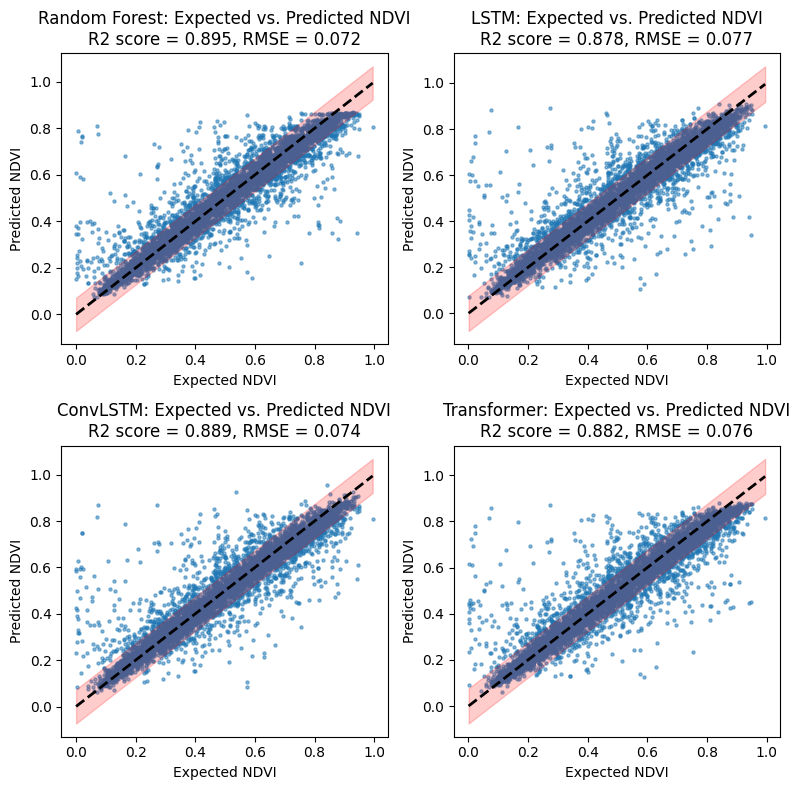

In [ ]:

# Create a 2x2 grid of subplots for the 4 different models
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Set titles and labels
titles = ['Random Forest', 'LSTM', 'ConvLSTM', 'Transformer']
predictions = [rf_inverse_y_pred_test, lstm_inverse_y_pred_test, convlstm_inverse_y_pred_test, transformer_inverse_y_pred_test]
r2_scores = [r2_rf_test, r2_lstm_test, r2_convlstm_test, r2_transformer_test]
rmse_scores = [rmse_rf_test, rmse_lstm_test, rmse_convlstm_test, rmse_transformer_test]

for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test, predictions[idx], s=5, alpha=0.5)
    
    # One-to-one line
    ax.plot([min(inverse_y_test), max(inverse_y_test)], [min(inverse_y_test), max(inverse_y_test)], 'k--', lw=2)
    
    # Deviation line
    deviation = np.std(inverse_y_test - predictions[idx])
    ax.fill_between(np.sort(inverse_y_test), np.sort(inverse_y_test) - deviation, np.sort(inverse_y_test) + deviation, alpha=0.2, color='r')
    
    ax.set_xlabel('Expected NDVI')
    ax.set_ylabel('Predicted NDVI')
    ax.set_title(f'{titles[idx]}: Expected vs. Predicted NDVI\nR2 score = {r2_scores[idx]:.3f}, RMSE = {rmse_scores[idx]:.3f}')

plt.tight_layout()
plt.show()

**- MSE histogram**

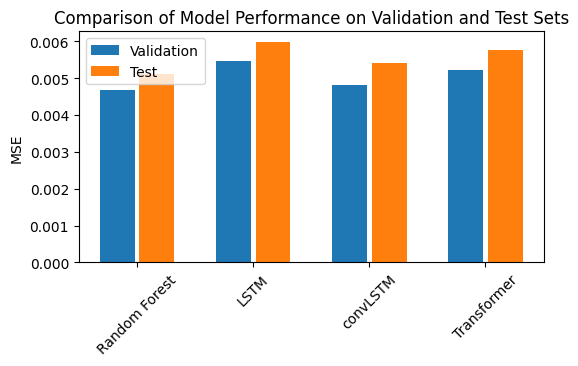

In [ ]:
# Compare the Mean Squared Error (MSE) for models

# Plot bar chart
plt.figure(figsize=(6, 3))
x = np.arange(4)
width = 0.3

plt.bar(x - 0.17, [mse_rf_val, mse_lstm_val, mse_convlstm_val, mse_transformer_val], width, label='Validation')
plt.bar(x + 0.17, [mse_rf_test, mse_lstm_test, mse_convlstm_test, mse_transformer_test], width, label='Test')
plt.xticks(ticks=x, labels=['Random Forest', 'LSTM' ,'convLSTM', 'Transformer'],
           rotation=45)
plt.ylabel('MSE')
plt.title('Comparison of Model Performance on Validation and Test Sets')
_ = plt.legend()
plt.show()



**- Residual plot**

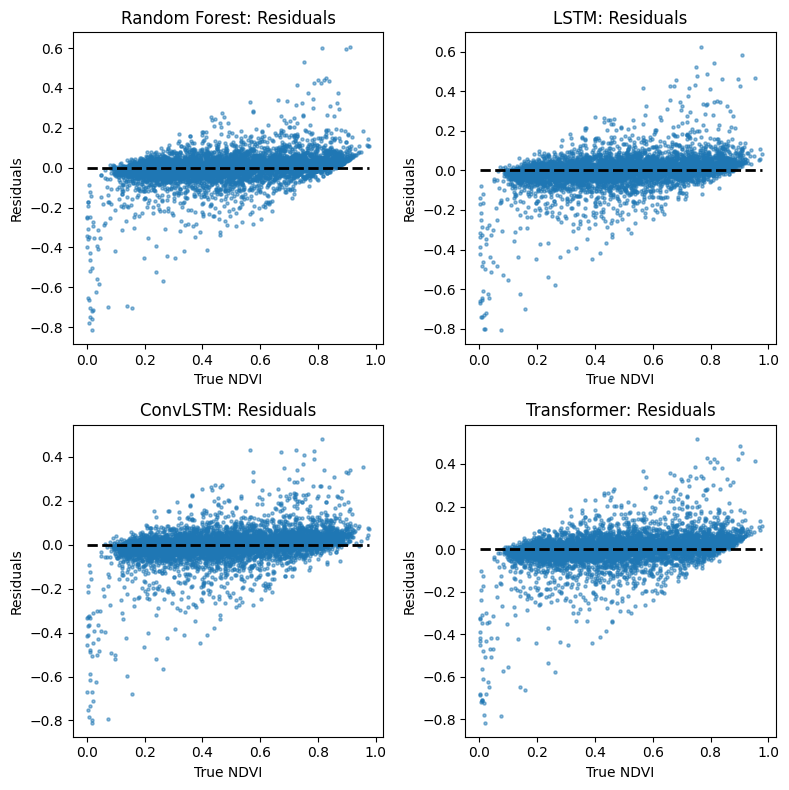

In [ ]:
#residual plot

residuals_rf = inverse_y_test - rf_inverse_y_pred_test
residuals_lstm = inverse_y_test - lstm_inverse_y_pred_test

# Create a 2x2 grid of subplots for the 4 different models
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Set titles and labels
titles = ['Random Forest', 'LSTM', 'ConvLSTM', 'Transformer']
predictions = [rf_inverse_y_pred_test, lstm_inverse_y_pred_test, convlstm_inverse_y_pred_test, transformer_inverse_y_pred_test]

# Calculate residuals for each model
residuals = [inverse_y_test - pred for pred in predictions]

for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test, residuals[idx], s=5, alpha=0.5)
    
    # Zero line
    ax.hlines(0, min(inverse_y_test), max(inverse_y_test), colors='k', linestyles='--', lw=2)

    
    ax.set_xlabel('True NDVI')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{titles[idx]}: Residuals')

plt.tight_layout()
plt.show()


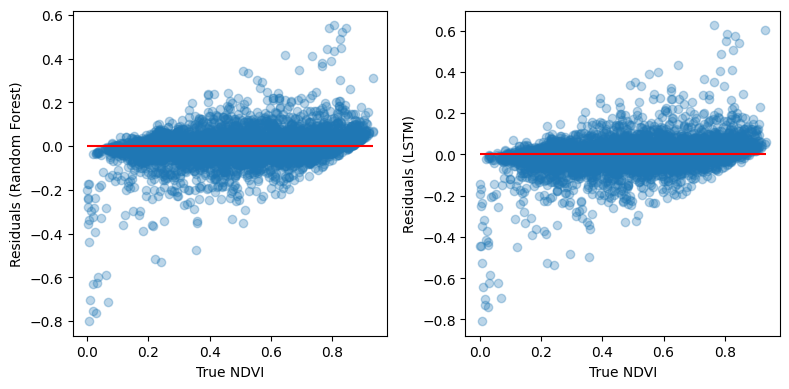

In [ ]:
#residual plot

residuals_rf = inverse_y_test - rf_inverse_y_pred_test
residuals_lstm = inverse_y_test - lstm_inverse_y_pred_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Scatter plot for Random Forest residuals
ax1.scatter(inverse_y_test, residuals_rf, alpha=0.3)
ax1.set_xlabel('True NDVI')
ax1.set_ylabel('Residuals (Random Forest)')
ax1.hlines(0, min(inverse_y_test), max(inverse_y_test), color='red')  # Line at zero

# Scatter plot for LSTM residuals
ax2.scatter(inverse_y_test, residuals_lstm, alpha=0.3)
ax2.set_xlabel('True NDVI')
ax2.set_ylabel('Residuals (LSTM)')
ax2.hlines(0, min(inverse_y_test), max(inverse_y_test), color='red')  # Line at zero

plt.tight_layout()
plt.show()

**- NDVI in timeseries**

In [ ]:
# Convert numpy arrays to dataframes
inverse_y_test_avg_df = pd.DataFrame(inverse_y_test, columns=['True NDVI'])
rf_inverse_y_pred_test_df = pd.DataFrame(rf_inverse_y_pred_test, columns=['Predicted NDVI (Random Forest)'])
lstm_inverse_y_pred_test_df = pd.DataFrame(lstm_inverse_y_pred_test, columns=['Predicted NDVI (LSTM)'])
convlstm_inverse_y_pred_test_df = pd.DataFrame(convlstm_inverse_y_pred_test, columns=['Predicted NDVI (ConvLSTM)'])
transformer_inverse_y_pred_test_df = pd.DataFrame(transformer_inverse_y_pred_test, columns=['Predicted NDVI (Transformer)'])

# Merge dataframes into a single dataframe
merged_df = pd.concat([inverse_y_test_avg_df, rf_inverse_y_pred_test_df, lstm_inverse_y_pred_test_df, convlstm_inverse_y_pred_test_df, transformer_inverse_y_pred_test_df ], axis=1)


In [ ]:
merged_df

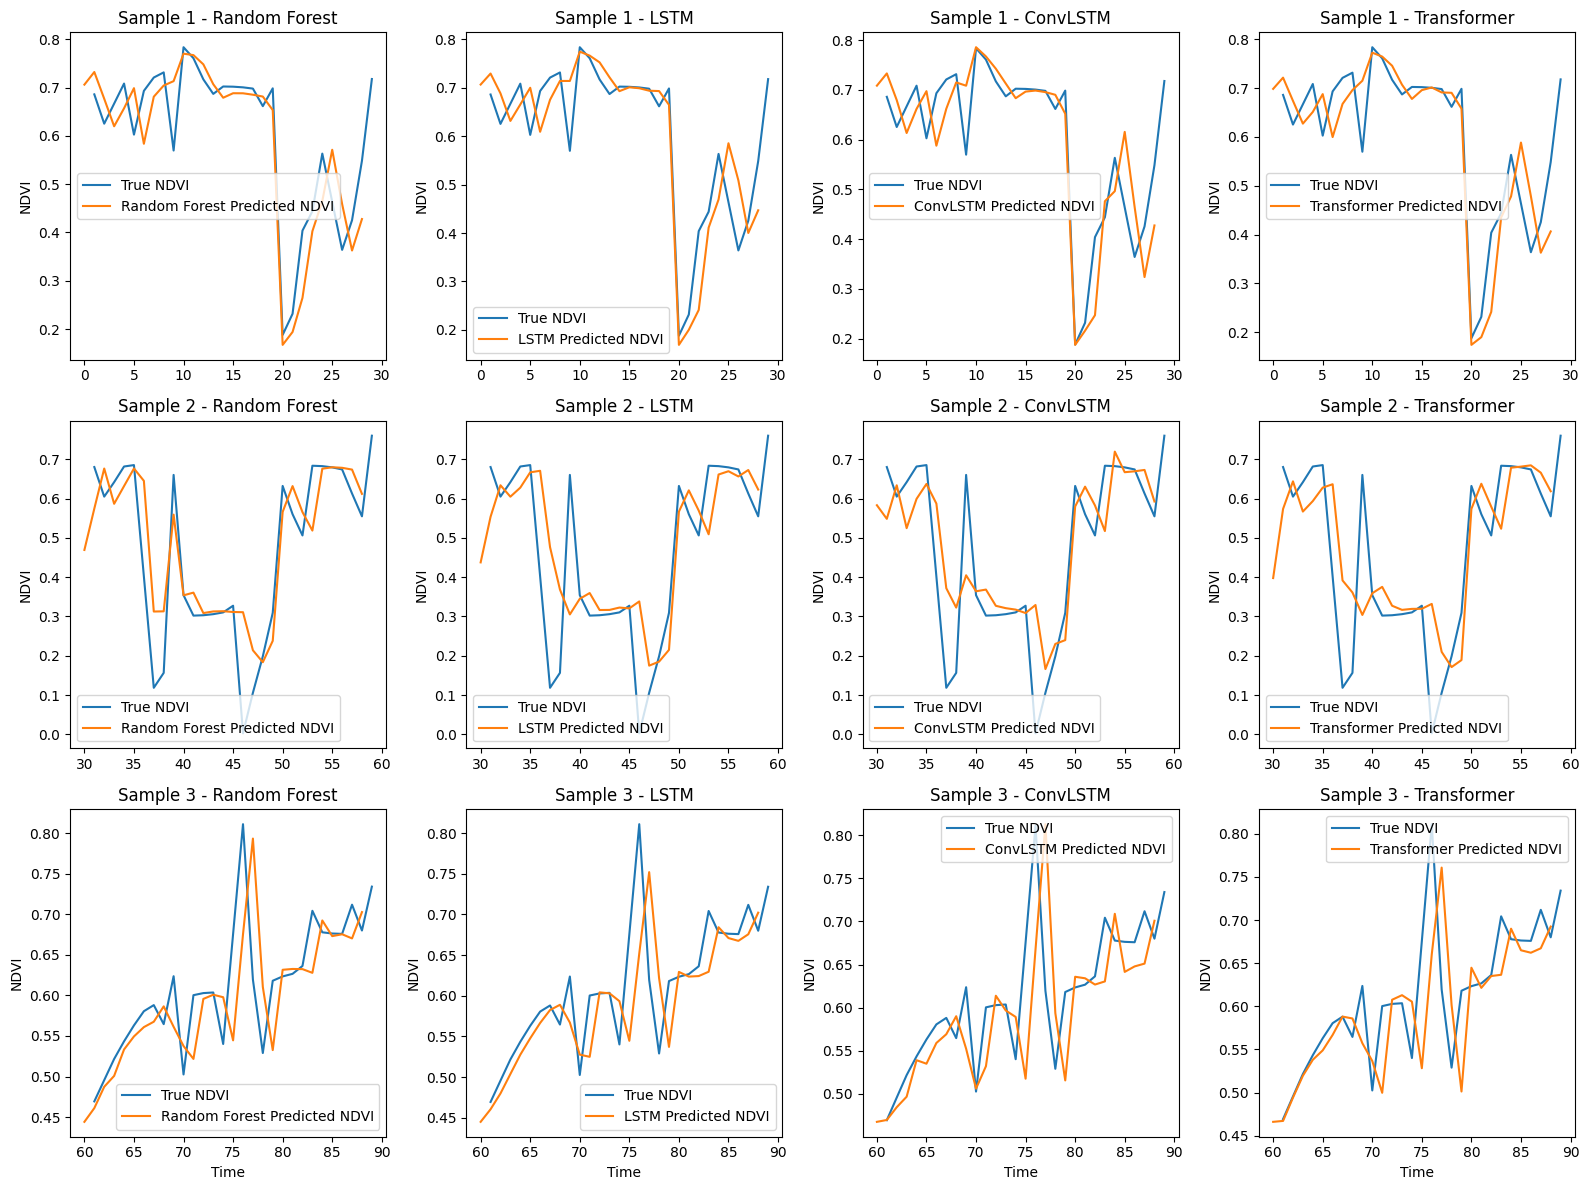

In [ ]:
# Select the first 90 rows
df_subset = merged_df.iloc[:90]

# Create a figure with twelve subplots
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

# Plot True NDVI and Predicted NDVI from each model
models = ['Random Forest', 'LSTM', 'ConvLSTM', 'Transformer']
for i in range(3):  # for each sample
    for j, model in enumerate(models):  # for each model
        start = i * 30
        end = (i+1) * 30

        # Plot True NDVI and Predicted NDVI for each model
        axs[i, j].plot(df_subset.index[start+1:end], df_subset['True NDVI'].values[start+1:end], label='True NDVI')
        axs[i, j].plot(df_subset.index[start:end-1], df_subset[f'Predicted NDVI ({model})'].values[start:end-1], label=f'{model} Predicted NDVI')
        axs[i, j].set_ylabel('NDVI')
        axs[i, j].legend()
        axs[i, j].set_title(f'Sample {i+1} - {model}')

# Add labels to the last row
for j in range(4):
    axs[2, j].set_xlabel('Time')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# 4. View the single and multiple steps prediction performance

## 4.1 Single prediction step

1/1 [==============================] - 0s 23ms/step


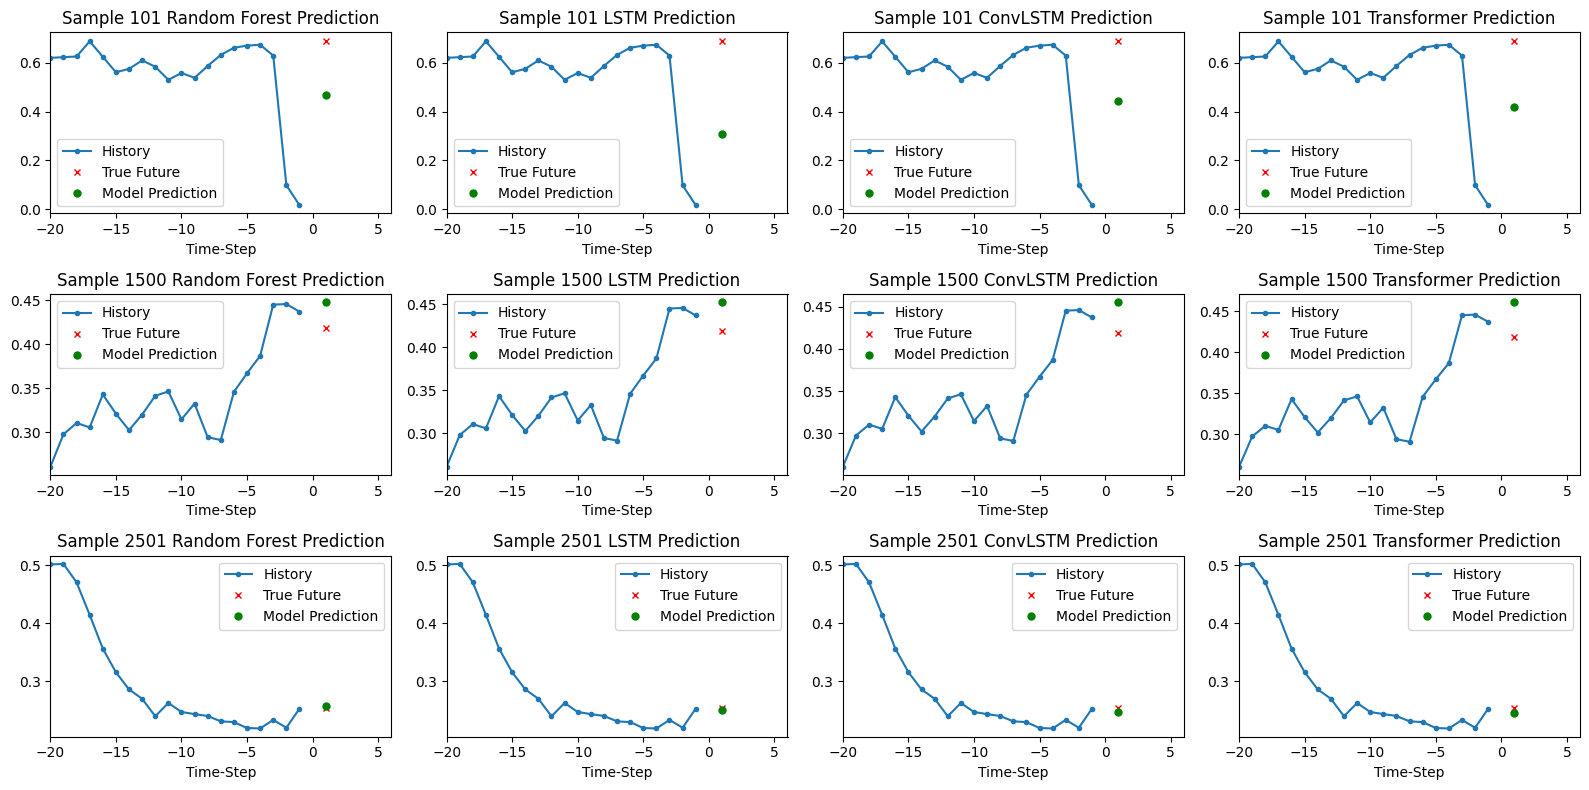

In [ ]:
import matplotlib.pyplot as plt

def show_plot(plot_data, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], (future + 2) * 2])
    ax.set_xlabel("Time-Step")

# Prepare data for the plot
n = 3  # number of samples to visualize
specified_indices = [100, 1499, 2500]  # samples 1, 1000 and 3000

fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(16, 8))  # adjust figsize as needed

for i, idx in enumerate(specified_indices):
    x_sample = X_test_reshaped[idx]
    y_sample = y_test[idx]
    history_ndvi = x_sample[:, 0, 0, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample

    # Random Forest
    x_sample_rf = x_sample.reshape(1, -1)
    y_pred_rf = rf_model.predict(x_sample_rf)[0]
    ax = axes[i, 0]
    show_plot([history_ndvi, true_future, y_pred_rf], f"Sample {idx + 1} Random Forest Prediction", ax)

    # LSTM
    x_sample_lstm = x_sample[np.newaxis, :, 0, 0]
    y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
    ax = axes[i, 1]
    show_plot([history_ndvi, true_future, y_pred_lstm], f"Sample {idx + 1} LSTM Prediction", ax)
    
    # ConvLSTM
    x_sample_convlstm = x_sample[np.newaxis, :, :, :, :]
    y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
    ax = axes[i, 2]
    show_plot([history_ndvi, true_future, y_pred_convlstm], f"Sample {idx + 1} ConvLSTM Prediction", ax)
    
    # Transformer
    x_sample_transformer = x_sample[np.newaxis, :, 0, 0]
    y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]
    ax = axes[i, 3]
    show_plot([history_ndvi, true_future, y_pred_transformer], f"Sample {idx + 1} Transformer Prediction", ax)

plt.tight_layout()
plt.show()


In [ ]:
y_pred_convlstm.shape

(1,)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(delta, delta + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], delta + n_steps])
    ax.set_xlabel("Time-Step")

# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=4, figsize=(16, 8))

# Number of future steps
n_steps = 5  

for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm, preds_convlstm, preds_transformer = [], [], [], []
    x_sample_rf = X_test[idx].reshape(1, -1)  
    x_sample_lstm = X_test[idx][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[idx][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Add the prediction to the list
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])
        preds_convlstm.append(y_pred_convlstm[0])
        preds_transformer.append(y_pred_transformer[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    # Select the next `n_steps` true future values for plotting
    true_future = y_test[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test[idx][:, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_rf], 1, f"Sample {idx + 1} RF Prediction", axes[i, 0])
    show_plot([history_ndvi, true_future, preds_lstm], 1, f"Sample {idx + 1} LSTM Prediction", axes[i, 1])
    show_plot([history_ndvi, true_future, preds_convlstm], 1, f"Sample {idx + 1} ConvLSTM Prediction", axes[i, 2])
    show_plot([history_ndvi, true_future, preds_transformer], 1, f"Sample {idx + 1} Transformer Prediction", axes[i, 3])
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_plot(plot_data, delta, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-plot_data[0].shape[0], 0))
    future = np.arange(delta, delta + len(plot_data[2]))

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i == 0:  # History
            ax.plot(time_steps, val.flatten(), marker[i], label=labels[i])
        elif i == 1:  # True Future
            ax.plot(future[:len(val)], val, marker[i], markersize=5, label=labels[i])
        elif i == 2:  # Model Prediction
            ax.plot(future, val, marker[i], markersize=5, label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], delta + n_steps])
    ax.set_xlabel("Time-Step")

# specify indices to visualize
specified_indices = [100, 1499, 2500]

# Create figure and axes
fig, axes = plt.subplots(nrows=len(specified_indices), ncols=4, figsize=(16, 8))

# Number of future steps
n_steps = 10  

for i, idx in enumerate(specified_indices):
    preds_rf, preds_lstm, preds_convlstm, preds_transformer = [], [], [], []
    x_sample_rf = X_test[idx].reshape(1, -1)  
    x_sample_lstm = X_test[idx][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[idx][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    # Predict future values
    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Add the prediction to the list
        preds_rf.append(y_pred_rf[0])
        preds_lstm.append(y_pred_lstm[0])
        preds_convlstm.append(y_pred_convlstm[0])
        preds_transformer.append(y_pred_transformer[0])

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    # Select the next `n_steps` true future values for plotting
    true_future = y_test[idx: idx+n_steps]

    # Plot history, true future, and model predictions
    history_ndvi = X_test[idx][:, 0]  # Select only NDVI_scaled from input_vars
    show_plot([history_ndvi, true_future, preds_rf], 1, f"Sample {idx + 1} RF Prediction", axes[i, 0])
    show_plot([history_ndvi, true_future, preds_lstm], 1, f"Sample {idx + 1} LSTM Prediction", axes[i, 1])
    show_plot([history_ndvi, true_future, preds_convlstm], 1, f"Sample {idx + 1} ConvLSTM Prediction", axes[i, 2])
    show_plot([history_ndvi, true_future, preds_transformer], 1, f"Sample {idx + 1} Transformer Prediction", axes[i, 3])

plt.tight_layout()
plt.show()


## 4.2 Multiple prediction steps

## 4.3 View the prediction ability of models on different prediction timesteps

In [ ]:
y_sample.shape

(1,)

In [ ]:
y_samples[i, :]

array([0.53791157, 0.53791157, 0.53791157, 0.53791157, 0.53791157])

In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
X_test_reshaped = X_test_reshaped[:1000]
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros((n_samples, n_steps))  
lstm_predictions = np.zeros((n_samples, n_steps))  
convlstm_predictions = np.zeros((n_samples, n_steps))  
transformer_predictions = np.zeros((n_samples, n_steps))  
y_samples = np.zeros((n_samples, n_steps)) 

# Number of future steps
n_steps = 1  

# Generate predictions for each sample in the test set
for i in range(n_samples):
    x_sample_rf = X_test[i].reshape(1, -1)  
    x_sample_lstm = X_test[i][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[i][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    y_sample = y_test[i : i + n_steps]

    for j in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Add the prediction to the list
        rf_predictions[i, j] = y_pred_rf[0]
        lstm_predictions[i, j] = y_pred_lstm[0]
        convlstm_predictions[i, j] = y_pred_convlstm[0]
        transformer_predictions[i, j] = y_pred_transformer[0]

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    y_samples[i, :] = y_sample.flatten()

# Compute and print R2 score for each model at each timestep
for timestep in range(n_steps):
    r2_rf = r2_score(y_samples[:, timestep], rf_predictions[:, timestep])
    r2_lstm = r2_score(y_samples[:, timestep], lstm_predictions[:, timestep])
    r2_convlstm = r2_score(y_samples[:, timestep], convlstm_predictions[:, timestep])
    r2_transformer = r2_score(y_samples[:, timestep], transformer_predictions[:, timestep])

    print(f"R2 score at timestep {timestep+1} - RF: {r2_rf}, LSTM: {r2_lstm}, ConvLSTM: {r2_convlstm}, Transformer: {r2_transformer}")


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
X_test_reshaped = X_test_reshaped[:1000]  # Assuming X_test_reshaped is your ConvLSTM ready input
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros(n_samples)  
lstm_predictions = np.zeros(n_samples)  
convlstm_predictions = np.zeros(n_samples)  
transformer_predictions = np.zeros(n_samples)  
y_samples = np.zeros(n_samples) 

# Number of future steps
n_steps = 5  

# Generate predictions for each sample in the test set
for i in range(n_samples - n_steps):  # Subtract n_steps because we're forecasting n_steps ahead
    x_sample_rf = X_test[i].reshape(1, -1)  
    x_sample_lstm = X_test[i][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[i][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    # Add the final prediction to the array (5th future timestep)
    rf_predictions[i] = y_pred_rf[0]
    lstm_predictions[i] = y_pred_lstm[0]
    convlstm_predictions[i] = y_pred_convlstm[0]
    transformer_predictions[i] = y_pred_transformer[0]

    # Add the true future value at the 5th timestep to the array
    y_samples[i] = y_test[i + n_steps]

# Compute and print R2 score for the 5th timestep
r2_rf = r2_score(y_samples[:-n_steps], rf_predictions[:-n_steps])
r2_lstm = r2_score(y_samples[:-n_steps], lstm_predictions[:-n_steps])
r2_convlstm = r2_score(y_samples[:-n_steps], convlstm_predictions[:-n_steps])
r2_transformer = r2_score(y_samples[:-n_steps], transformer_predictions[:-n_steps])
print(f"R2 score at timestep {n_steps} - RF: {r2_rf}, LSTM: {r2_lstm}, ConvLSTM: {r2_convlstm}, Transformer: {r2_transformer}")


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
X_test_reshaped = X_test_reshaped[:1000]
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros(n_samples)  
lstm_predictions = np.zeros(n_samples)
convlstm_predictions = np.zeros(n_samples)
transformer_predictions = np.zeros(n_samples) 
y_samples = np.zeros(n_samples)

# Number of future steps
n_steps = 10  

# Generate predictions for each sample in the test set
for i in range(n_samples - n_steps):  # Subtract n_steps because we're forecasting n_steps ahead
    x_sample_rf = X_test[i].reshape(1, -1)  
    x_sample_lstm = X_test[i][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[i][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    # Add the final prediction to the array (10th future timestep)
    rf_predictions[i] = y_pred_rf[0]
    lstm_predictions[i] = y_pred_lstm[0]
    convlstm_predictions[i] = y_pred_convlstm[0]
    transformer_predictions[i] = y_pred_transformer[0]

    # Add the true future value at the 10th timestep to the array
    y_samples[i] = y_test[i + n_steps]

# Compute and print R2 score for the 10th timestep
r2_rf = r2_score(y_samples[:-n_steps], rf_predictions[:-n_steps])
r2_lstm = r2_score(y_samples[:-n_steps], lstm_predictions[:-n_steps])
r2_convlstm = r2_score(y_samples[:-n_steps], convlstm_predictions[:-n_steps])
r2_transformer = r2_score(y_samples[:-n_steps], transformer_predictions[:-n_steps])

print(f"R2 score at timestep {n_steps} - RF: {r2_rf}, LSTM: {r2_lstm}, ConvLSTM: {r2_convlstm}, Transformer: {r2_transformer}")


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
X_test_reshaped = X_test_reshaped[:1000]
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros(n_samples)  
lstm_predictions = np.zeros(n_samples)
convlstm_predictions = np.zeros(n_samples)
transformer_predictions = np.zeros(n_samples) 
y_samples = np.zeros(n_samples)

# Number of future steps
n_steps = 10  

# Generate predictions for each sample in the test set
for i in range(n_samples - n_steps):  # Subtract n_steps because we're forecasting n_steps ahead
    x_sample_rf = X_test[i].reshape(1, -1)  
    x_sample_lstm = X_test[i][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[i][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    for _ in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

    # Add the final prediction to the array (10th future timestep)
    rf_predictions[i] = y_pred_rf[0]
    lstm_predictions[i] = y_pred_lstm[0]
    convlstm_predictions[i] = y_pred_convlstm[0]
    transformer_predictions[i] = y_pred_transformer[0]

    # Add the true future value at the 10th timestep to the array
    y_samples[i] = y_test[i + n_steps]

In [ ]:
y_samples

In [ ]:
print(y_samples.ndim)  # prints the number of dimensions
print(y_samples.shape)  # prints the shape of the array


1
(1000,)


In [ ]:
np.save('y_samples.npy', y_samples)

In [ ]:
y_samples= np.load('y_samples.npy')

In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Limiting the test set size to 1000
X_test = X_test[:1000]
X_test_reshaped = X_test_reshaped[:1000]
y_test = y_test[:1000]

n_samples = len(X_test)  # Total samples in the test set

# Prepare arrays to store the expected and predicted values
rf_predictions = np.zeros((n_samples, n_steps))  
lstm_predictions = np.zeros((n_samples, n_steps))
convlstm_predictions = np.zeros((n_samples, n_steps))
transformer_predictions = np.zeros((n_samples, n_steps)) 
y_samples = np.zeros((n_samples, n_steps))

# Number of future steps
n_steps = 10  

# Generate predictions for each sample in the test set
from tqdm import tqdm  # for the progress bar
for i in tqdm(range(n_samples - n_steps)):  # Subtract n_steps because we're forecasting n_steps ahead
    x_sample_rf = X_test[i].reshape(1, -1)  
    x_sample_lstm = X_test[i][np.newaxis, :, :] 
    x_sample_convlstm = X_test_reshaped[i][np.newaxis, :, :, :, :]
    x_sample_transformer = x_sample_lstm  # Assuming the transformer takes the same input shape as the LSTM

    for j in range(n_steps):
        y_pred_rf = rf_model.predict(x_sample_rf)
        y_pred_lstm = lstm_model.predict(x_sample_lstm)[0]
        y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
        y_pred_transformer = simplified_transformer_model.predict(x_sample_transformer)[0]

        # Update x_sample to include the new prediction and exclude the first value
        x_sample_rf = np.roll(x_sample_rf, -1)
        x_sample_rf[-1] = y_pred_rf  

        x_sample_lstm = np.roll(x_sample_lstm, -1, axis=1)
        x_sample_lstm[0, -1, 0] = y_pred_lstm  # Update the last value with the new prediction

        x_sample_convlstm = np.roll(x_sample_convlstm, -1, axis=1)
        x_sample_convlstm[0, -1, 0, 0, 0] = y_pred_convlstm  # Update the last value with the new prediction

        x_sample_transformer = np.roll(x_sample_transformer, -1, axis=1)
        x_sample_transformer[0, -1, 0] = y_pred_transformer  # Update the last value with the new prediction

        # Store the prediction at each step
        rf_predictions[i, j] = y_pred_rf[0]
        lstm_predictions[i, j] = y_pred_lstm[0]
        convlstm_predictions[i, j] = y_pred_convlstm[0]
        transformer_predictions[i, j] = y_pred_transformer[0]

        # Add the true future value at the corresponding timestep to the array
        y_samples[i, j] = y_test[i + j]


In [ ]:
np.save('y_samples_all.npy', y_samples)

In [ ]:
y_samples = np.load('y_samples_all.npy')

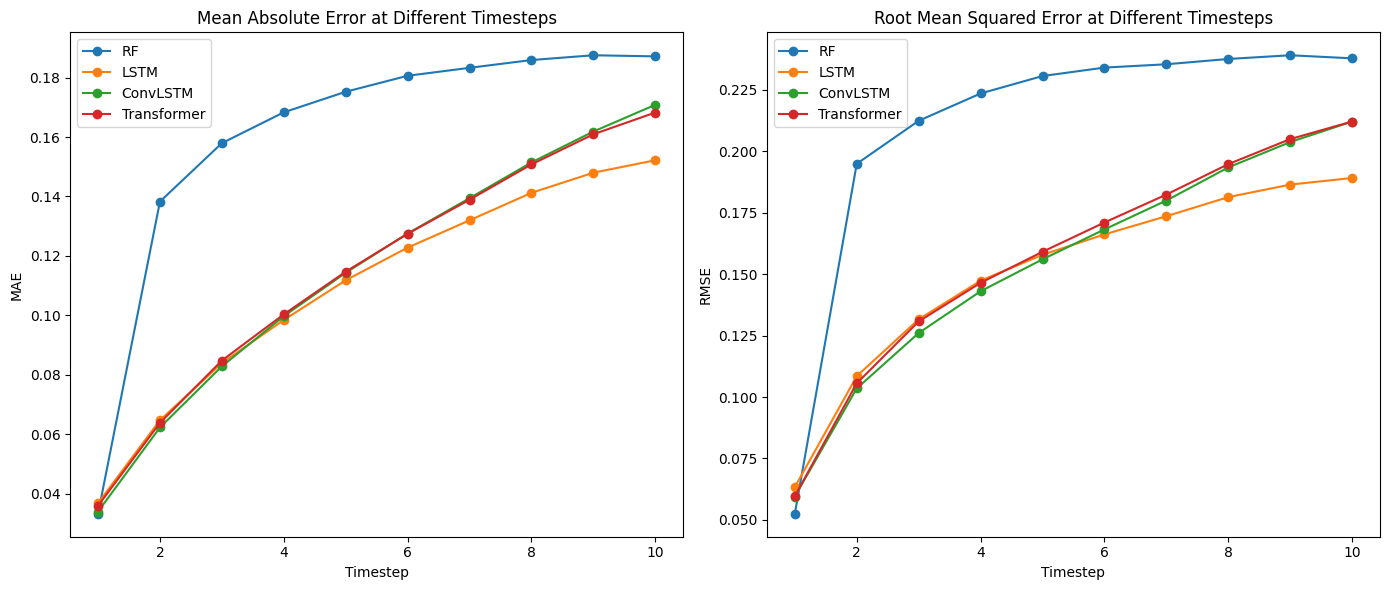

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Prepare lists to store MAE and RMSE values for all models
mae_values_rf = []
rmse_values_rf = []
mae_values_lstm = []
rmse_values_lstm = []
mae_values_convlstm = []
rmse_values_convlstm = []
mae_values_transformer = []
rmse_values_transformer = []

# Calculate MAE and RMSE for each timestep
for step in range(n_steps):
    y_samples_timestep = y_samples[:, step]

    # Calculate and store MAE and RMSE for each model
    for predictions, mae_values, rmse_values in [
        (rf_predictions, mae_values_rf, rmse_values_rf),
        (lstm_predictions, mae_values_lstm, rmse_values_lstm),
        (convlstm_predictions, mae_values_convlstm, rmse_values_convlstm),
        (transformer_predictions, mae_values_transformer, rmse_values_transformer),
    ]:
        predictions_timestep = predictions[:, step]
        
        mae = mean_absolute_error(y_samples_timestep, predictions_timestep)
        rmse = sqrt(mean_squared_error(y_samples_timestep, predictions_timestep))

        mae_values.append(mae)
        rmse_values.append(rmse)

# Indices for X-axis for the plot
timesteps = list(range(1, n_steps+1))

# Create a figure with two subplots - one for MAE and another for RMSE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the MAE values
for mae_values, label in [
    (mae_values_rf, 'RF'), 
    (mae_values_lstm, 'LSTM'), 
    (mae_values_convlstm, 'ConvLSTM'), 
    (mae_values_transformer, 'Transformer')
]:
    ax[0].plot(timesteps, mae_values, marker='o', label=label)

ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('MAE')
ax[0].set_title('Mean Absolute Error at Different Timesteps')
ax[0].legend()


# Plotting the RMSE values
for rmse_values, label in [
    (rmse_values_rf, 'RF'), 
    (rmse_values_lstm, 'LSTM'), 
    (rmse_values_convlstm, 'ConvLSTM'), 
    (rmse_values_transformer, 'Transformer')
]:
    ax[1].plot(timesteps, rmse_values, marker='o', label=label)


ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Root Mean Squared Error at Different Timesteps')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


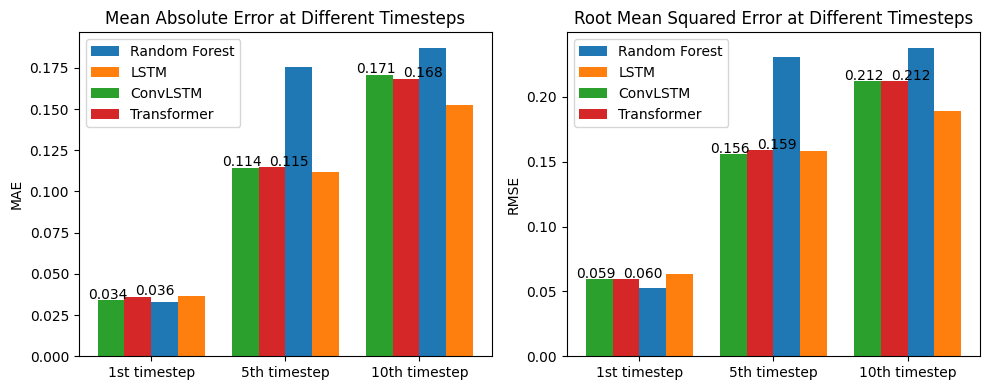

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# Store the metric values for each model
mae_values_convlstm = []
rmse_values_convlstm = []
mae_values_transformer = []
rmse_values_transformer = []
mae_values_rf = []
rmse_values_rf = []
mae_values_lstm = []
rmse_values_lstm = []

# Select the specific timestep values
for step in [0, 4, 9]:  # 1st, 5th and 10th timestep
    y_samples_timestep = y_samples[:, step]
    convlstm_predictions_timestep = convlstm_predictions[:, step]
    transformer_predictions_timestep = transformer_predictions[:, step]
    rf_predictions_timestep = rf_predictions[:, step]
    lstm_predictions_timestep = lstm_predictions[:, step]

    # Compute the metrics for ConvLSTM model
    mae_convlstm = mean_absolute_error(y_samples_timestep, convlstm_predictions_timestep)
    rmse_convlstm = sqrt(mean_squared_error(y_samples_timestep, convlstm_predictions_timestep))
    
    # Compute the metrics for Transformer model
    mae_transformer = mean_absolute_error(y_samples_timestep, transformer_predictions_timestep)
    rmse_transformer = sqrt(mean_squared_error(y_samples_timestep, transformer_predictions_timestep))
    
    # Compute the metrics for Random Forest model
    mae_rf = mean_absolute_error(y_samples_timestep, rf_predictions_timestep)
    rmse_rf = sqrt(mean_squared_error(y_samples_timestep, rf_predictions_timestep))
    
    # Compute the metrics for LSTM model
    mae_lstm = mean_absolute_error(y_samples_timestep, lstm_predictions_timestep)
    rmse_lstm = sqrt(mean_squared_error(y_samples_timestep, lstm_predictions_timestep))

    # Append the calculated metric values to the lists
    mae_values_convlstm.append(mae_convlstm)
    rmse_values_convlstm.append(rmse_convlstm)
    mae_values_transformer.append(mae_transformer)
    rmse_values_transformer.append(rmse_transformer)
    mae_values_rf.append(mae_rf)
    rmse_values_rf.append(rmse_rf)
    mae_values_lstm.append(mae_lstm)
    rmse_values_lstm.append(rmse_lstm)

# Indices for X-axis for the plot
indices = np.arange(3)

# Width of a bar in the bar plot
width = 0.2

# Creating a figure with two subplots - one for MAE and another for RMSE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the MAE values
ax[0].bar(indices + 2*width, mae_values_rf, width, label='Random Forest')
ax[0].bar(indices + 3*width, mae_values_lstm, width, label='LSTM')
ax[0].bar(indices, mae_values_convlstm, width, label='ConvLSTM')
ax[0].bar(indices + width, mae_values_transformer, width, label='Transformer')

ax[0].set_ylabel('MAE')
ax[0].set_title('Mean Absolute Error at Different Timesteps')
ax[0].set_xticks(indices + 1.5*width)
ax[0].set_xticklabels(['1st timestep', '5th timestep', '10th timestep'])
ax[0].legend()

# Display the MAE values above each bar
for i, v in enumerate(mae_values_convlstm):
    ax[0].text(i - 0.17, v + 0.001, f"{v:.3f}")
for i, v in enumerate(mae_values_transformer):
    ax[0].text(i + 0.18, v + 0.001, f"{v:.3f}")

# Plotting the RMSE values
ax[1].bar(indices + 2*width, rmse_values_rf, width, label='Random Forest')
ax[1].bar(indices + 3*width, rmse_values_lstm, width, label='LSTM')
ax[1].bar(indices, rmse_values_convlstm, width, label='ConvLSTM')
ax[1].bar(indices + width, rmse_values_transformer, width, label='Transformer')

ax[1].set_ylabel('RMSE')
ax[1].set_title('Root Mean Squared Error at Different Timesteps')
ax[1].set_xticks(indices + 1.5*width)
ax[1].set_xticklabels(['1st timestep', '5th timestep', '10th timestep'])
ax[1].legend()

# Display the RMSE values above each bar
for i, v in enumerate(rmse_values_convlstm):
    ax[1].text(i - 0.17, v + 0.001, f"{v:.3f}")
for i, v in enumerate(rmse_values_transformer):
    ax[1].text(i + 0.18, v + 0.001, f"{v:.3f}")

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
df_expected

new


# Other models 

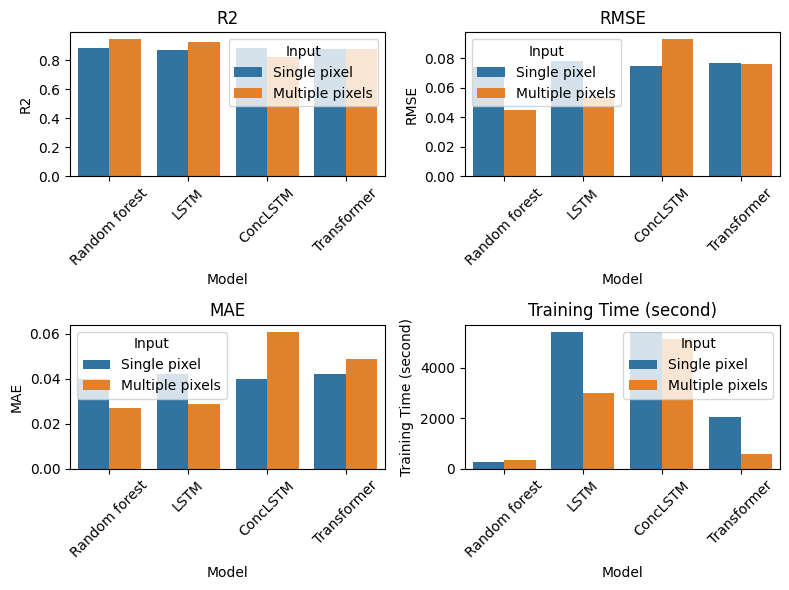

In [ ]:

# Define the data
data = {
    "Input": ["Single pixel", "Single pixel", "Single pixel", "Single pixel", "Multiple pixels", "Multiple pixels", "Multiple pixels", "Multiple pixels"],
    "Model": ["Random forest", "LSTM", "ConcLSTM", "Transformer", "Random forest", "LSTM", "ConcLSTM", "Transformer"],
    "R2": [0.888, 0.874, 0.885, 0.877, 0.947, 0.925, 0.825, 0.882],
    "RMSE": [0.074, 0.078, 0.075, 0.077, 0.045, 0.054, 0.093, 0.076],
    "MAE": [0.040, 0.042, 0.040, 0.042, 0.027, 0.029, 0.061, 0.049],
    "Training Time (second)": [246, 5442, 5442, 2035, 351, 3009, 5160, 587]
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Define the metrics
metrics = ['R2', 'RMSE', 'MAE', 'Training Time (second)']

for ax, metric in zip(axes.flatten(), metrics):
    # Create a bar plot for each metric
    sns.barplot(x='Model', y=metric, hue='Input', data=df, ax=ax)
    ax.set_title(metric)
    ax.tick_params(axis='x', rotation=45)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()